In [1]:
# import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import math
import statistics
import seaborn as sns
from IPython.display import display
import pingouin as pg
import researchpy   
%matplotlib inline

In [2]:
df_train = pd.read_csv('Titanic_train.csv',usecols = ['Age','Survived','Sex','Fare'])
df_train

,Survived,Sex,Age,Fare
0,0,male,22.0,7.2500
1,1,female,38.0,71.2833
2,1,female,26.0,7.9250
3,1,female,35.0,53.1000
4,0,male,35.0,8.0500
...,...,...,...,...
886,0,male,27.0,13.0000
887,1,female,19.0,30.0000
888,0,female,NaN,23.4500
889,1,male,26.0,30.0000


In [3]:
#開始探索性分析(EDA)
#觀察資料是否有遺失值
#判斷每一個資料點，是否為空值:
print(df_train.isnull().head(5))


# 会判断哪些”列”存在缺失值
# any：判斷一個tuple或者list是否全為空，0，False。如果全為空，0，False，則返回False；如果不全為空，則返回True。
print(df_train.isnull().any())

# 統計 data 裡有空值的變數個數
print(df_train.isnull().any().sum())

   Survived    Sex    Age   Fare
0     False  False  False  False
1     False  False  False  False
2     False  False  False  False
3     False  False  False  False
4     False  False  False  False
Survived    False
Sex         False
Age          True
Fare        False
dtype: bool
1


In [4]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   Fare      891 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 28.0+ KB
None


In [5]:
#我們先把遺失值刪除
complete_data=df_train[['Age','Survived','Sex','Fare']].dropna()
display(complete_data)

,Age,Survived,Sex,Fare
0,22.0,0,male,7.2500
1,38.0,1,female,71.2833
2,26.0,1,female,7.9250
3,35.0,1,female,53.1000
4,35.0,0,male,8.0500
...,...,...,...,...
885,39.0,0,female,29.1250
886,27.0,0,male,13.0000
887,19.0,1,female,30.0000
889,26.0,1,male,30.0000


In [6]:
#這邊我們做一個調整，把 Survived 變成離散型變數 Survived_cate
complete_data['Survived_cate']=complete_data['Survived']
complete_data['Survived_cate']=complete_data['Survived_cate'].astype('object')
print(complete_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            714 non-null    float64
 1   Survived       714 non-null    int64  
 2   Sex            714 non-null    object 
 3   Fare           714 non-null    float64
 4   Survived_cate  714 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 33.5+ KB
None


In [7]:
#找出離散型資料
#只有Sex是離散資料
cat_features = []
for dtype, feature in zip(complete_data.dtypes, complete_data.columns):
    if dtype == 'object':
        cat_features.append(feature)
print(f'{len(cat_features)} category Features : {cat_features}\n')

2 category Features : ['Sex', 'Survived_cate']



In [8]:
#Q1:透過Eta Squared數值法計算 Age 和 Survived 是否有相關性
aov = pg.anova(dv='Age', between='Survived_cate', data=complete_data, detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Survived_cate,897.187582,1,897.187582,4.271195,0.039125,0.005963
1,Within,149559.448362,712,210.055405,NaN,NaN,NaN


In [9]:
etaSq = aov.SS[0] / (aov.SS[0] + aov.SS[1])
etaSq

0.0059630974469252

In [10]:
def judgment_etaSq(etaSq):
    if etaSq < .01:
        qual = 'Negligible'
    elif etaSq < .06:
        qual = 'Small'
    elif etaSq < .14:
        qual = 'Medium'
    else:
        qual = 'Large'
    return(qual)
judgment_etaSq(etaSq)
#Age 和 Survived 沒有相關性

'Negligible'

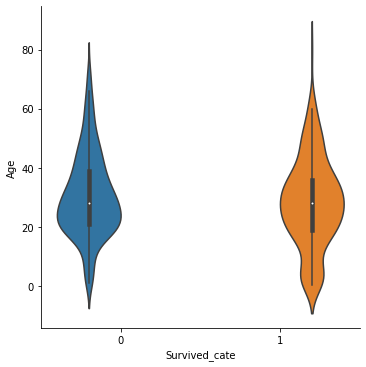

In [11]:
g = sns.catplot(x="Survived_cate", y="Age", hue="Survived_cate",
               data=complete_data, kind="violin")

In [12]:
#Q2:透過透過 Cramér's V數值法計算 Sex 和 Survived_cate 是否有相關性?
#step1: 用交叉列連表(contingency table)，來整理兩個類別型的資料
contTable = pd.crosstab(complete_data['Sex'], complete_data['Survived_cate'])
contTable

Survived_cate,0,1
Sex,,
female,64,197
male,360,93


In [13]:
#Step2:計算資料自由度 df*
df = min(contTable.shape[0], contTable.shape[1]) - 1
df

1

In [14]:
#Step3：計算出 Cramer’s V 係數
crosstab, res = researchpy.crosstab(complete_data['Sex'], complete_data['Survived_cate'], test='chi-square')
#print(res)
print("Cramer's value is",res.loc[2,'results'])

Cramer's value is 0.5388


In [15]:
## 寫一個副程式判斷相關性的強度
def judgment_CramerV(df,V):
    if df == 1:
        if V < 0.10:
            qual = 'negligible'
        elif V < 0.30:
            qual = 'small'
        elif V < 0.50:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 2:
        if V < 0.07:
            qual = 'negligible'
        elif V < 0.21:
            qual = 'small'
        elif V < 0.35:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 3:
        if V < 0.06:
            qual = 'negligible'
        elif V < 0.17:
            qual = 'small'
        elif V < 0.29:
            qual = 'medium'
        else:
            qual = 'large'
    elif df == 4:
        if V < 0.05:
            qual = 'negligible'
        elif V < 0.15:
            qual = 'small'
        elif V < 0.25:
            qual = 'medium'
        else:
            qual = 'large'
    else:
        if V < 0.05:
            qual = 'negligible'
        elif V < 0.13:
            qual = 'small'
        elif V < 0.22:
            qual = 'medium'
        else:
            qual = 'large'
    return(qual)
judgment_CramerV(df,res.loc[2,'results'])
#此案例的 Sex 和 Survived 是高度相關

'large'

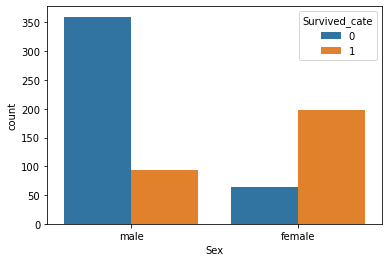

In [16]:
g= sns.countplot(x="Sex", hue="Survived_cate", data=complete_data)

In [17]:
#Q3: 透過Pearsonr數值法計算 Age 和 Fare 是否有相關性? 
corr, _=stats.pearsonr(complete_data['Fare'], complete_data['Age'])
print(corr)
#代表Age 和 Fare 是無線性關係

0.0960666917690389


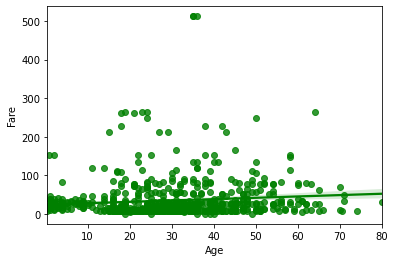

In [18]:
#作圖
g = sns.regplot(x="Age", y="Fare", color="g",data=complete_data)
#Age 和 Survived無線性關係